<a href="https://colab.research.google.com/github/darthgera123/Object-Detection/blob/master/MASKD_MMdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MASKD MMDetection V2 Solution
This dataset and notebook correspond to the [MASKD Challenge](https://www.aicrowd.com/challenges/aicrowd-blitz-2/problems/maskd) being held on [AIcrowd](https://www.aicrowd.com/).

[MMDetection](https://github.com/open-mmlab/mmdetection) is an amazing object detection library consisting of a pleothra of SOTA object detection learning algorithms. 

We use `htc_x101_64x4d_fpn` over 15 epochs to get a score of 0.444 on the leaderboard. The data was in COCO format. This notebook is a guide on using mmdetection in similar situations

## Downloads and Installations

### Install MMDetection

In [ ]:

!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

### Install PyCOCO tools 
Helps us interact with COCO based files for evaluation and inference

In [ ]:
!pip install "git+https://github.com/open-mmlab/cocoapi.git#subdirectory=pycocotools"


### Install Albumentations
Helps us with augmentations. Tackles all kinds including object detection and instance segmentation

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

### Download Data


In [ ]:
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/maskd/v0.1/train_images.zip
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/maskd/v0.1/val_images.zip
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/maskd/v0.1/test_images.zip
!unzip -q train_images.zip
!unzip -q val_images.zip
!unzip -q test_images.zip
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/maskd/v0.1/train.json
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/maskd/v0.1/val.json
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/maskd/v0.1/test.json

### Import Libraries

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())


1.5.1+cu101 True
2.3.0rc0+cd37b1f
10.1
GCC 7.5


## Dataset Creation
In PyTorch we have to create a custom data class for our custom data. This is similar in idea to that. If we have our data in COCO format we can simply inherit the class and mention the classes present

In [ ]:
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class MaskDataset(CocoDataset):

    CLASSES = ('mask','no_mask')

## Config Update
This is where we select the model and make required changes depending upon the model. Choose the required model. Make the changes in that file. 

In [ ]:
# Make sure to replace base with `without_semantic` for it to work
config_fname = 'configs/htc/htc_x101_64x4d_fpn_16x1_20e_coco.py'

In [ ]:
from mmcv import Config
from mmdet.apis import set_random_seed
import mmcv
cfg = Config.fromfile(config_fname)
cfg.dataset_type = 'MaskDataset'
cfg.data_root = '.'

cfg.data.train.type = 'MaskDataset'
cfg.data.train.data_root = '.'
cfg.data.train.ann_file = 'train.json'
cfg.data.train.img_prefix = 'train_images'

cfg.data.val.type = 'MaskDataset'
cfg.data.val.data_root = '.'
cfg.data.val.ann_file = 'val.json'
cfg.data.val.img_prefix = 'val_images'

cfg.data.test.type = 'MaskDataset'
cfg.data.test.data_root = '.'
cfg.data.test.ann_file = 'test.json'
cfg.data.test.img_prefix = 'test_images'

In [ ]:
## This line is needed if you want to make changes on num_classes for faster-rcnn variants
## for cascade this needs to be done manually
# cfg.model.roi_head.bbox_head.num_classes = 2

# cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
cfg.total_epochs = 20
# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 16
# required in some cases
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'bbox'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 4
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 4

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

## Training

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
import os.path as osp

# Build dataset
train_datasets = build_dataset(cfg.data.train)

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = train_datasets.CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, train_datasets, cfg, distributed=False, validate=True)

## Inference

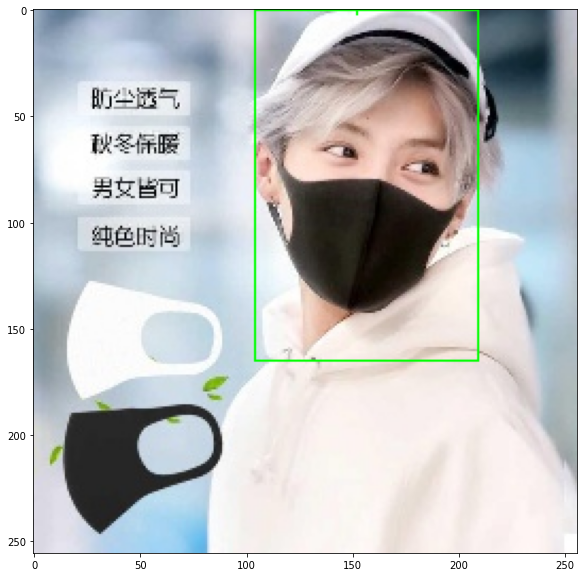

In [ ]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

img = mmcv.imread('mmdetection/train_images/0099a72207.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

## Evaluation

Create Dataloader for val dataset

In [ ]:
from mmdet.datasets import build_dataloader
cfg.data.test.test_mode = True
distributed = False
val_dataset = build_dataset(cfg.data.val)
data_loader = build_dataloader(
    val_dataset,
    samples_per_gpu=1,
    workers_per_gpu=1,
    dist=distributed,
    shuffle=False)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
WEIGHTS_FILE = './tutorial_exps/latest.pth'


In [ ]:
from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmdet.apis import single_gpu_test
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)
checkpoint = load_checkpoint(model, WEIGHTS_FILE, map_location='cpu')

model.CLASSES = val_dataset.CLASSES

model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader, False, None, 0.5)
val_dataset.format_results(outputs,'results')

2020-07-23 13:46:12,128 - mmdet - INFO - load model from: open-mmlab://resnext101_64x4d


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 120/120, 1.4 task/s, elapsed: 86s, ETA:     0s

({'bbox': 'results.bbox.json', 'proposal': 'results.bbox.json'}, None)

### Eval Results

In [ ]:
import random
import json
import numpy as np
import argparse
import base64
import glob
import os
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
IMAGES_DIR = "mmdetection/val_images"
GROUND_TRUTH_ANNOTATION_PATH = "mmdetection/val.json"
ground_truth_annotations = COCO(GROUND_TRUTH_ANNOTATION_PATH)
submission_file = json.loads(open("results.bbox.json").read())
results = ground_truth_annotations.loadRes(submission_file)
cocoEval = COCOeval(ground_truth_annotations, results, 'bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.04s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.161
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.477
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.044
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.180
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.205
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.168
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.346
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 

## Testing

In [ ]:
cfg.data.test.test_mode = True
distributed = False
test_dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
    test_dataset,
    samples_per_gpu=1,
    workers_per_gpu=1,
    dist=distributed,
    shuffle=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)
checkpoint = load_checkpoint(model, WEIGHTS_FILE, map_location='cpu')

model.CLASSES = test_dataset.CLASSES

model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader, False, None, 0.5)
test_dataset.format_results(outputs,'output1')

2020-07-23 14:06:13,089 - mmdet - INFO - load model from: open-mmlab://resnext101_64x4d


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 774/774, 1.3 task/s, elapsed: 588s, ETA:     0s

({'bbox': 'output1.bbox.json', 'proposal': 'output1.bbox.json'}, None)